<a href="https://colab.research.google.com/github/ronaldolg26/Data_Science_Airbnb/blob/main/Drone_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Efeito dos drones no e-commerce em São Paulo.

---



<img src='https://github.com/ronaldolg26/Efeito_drones_saopaulo/blob/main/drone-ifood-foto-divulgacao-960x540.jpg?raw=true' >

Dês dos primórdios das civilizações a busca pela troca de informações é algo em constate evolução. Na Pérsia antiga, por exemplo, surgiu o que pode ser considera o primeiro correio do mundo. Com centenas de estações espalhadas por todo o reinado os mensageiros montados a cavalo iam de um lugar a outro levando mensagens. Na França, em meados de 1653, as distâncias de 250km eram percorridas em 2 dias. Todavia, a mais fascinante das formas de transmitir algo para alguém se dava pela utilização dos pombos-correios que chegavam a velocidade de 70km/h.

Hoje, os transportes de mercadorias são feitos pelos os mais diversos meios de transporte. Navios, aviões, carros, motos, bicicletas e até patins entra na lista do modo de executar esse translado. Com o barateamento de novas tecnologias, um novo meio de transporte vem ganhado destaque nesse cenário pela sua eficiência e agilidade. Drones, são aeronaves não tripuladas de diversos tamanhos que inicialmente possuíam usos militares, mas que hoje em dia possuem uma variedade bem grande de utilizações, desde captação de imagens para eventos, transmissões de imagens para atividades jornalísticas e, em especial para esse notebook, entrega de objetos para lojas.


##Cenário brasileiro

No começo do ano de 2022, a Agência Nacional de Aviação Civil (ANAC) autorizou o Ifood, em parceria com Speedbird Aero, a realizar entregas com aeronaves remotamente pilotadas (RPAs) em todo o território brasileiro. “Com ela, os drones estão liberados para realizar entregas com cargas de até 2,5 quilos em um raio de 3 quilômetros, inclusive em ambientes urbanos, mantendo margens de segurança estabelecidas no projeto. ” Todavia, a empresa Speedbird Aero possui outros modelos de maior alcance, dessa forma é possível vislumbrar em um futuro próximo esse meio de entrega atingindo outros segmentos além das foodtechs. 

Esse notebook se propõe em estimar os impactos que essa nova tecnologia causará no e-commerce brasileiro. Para essa análise utilizaremos os padrões velocidade, carga e distância dos modelos de drones da Speesbird Aero, bem como os dados do e-commerce de São Paulo das marketplaces que hospedam seus dados na Olist, empresa essa que gentilmente cedeu seus dados de forma pública no Kaggle. Obrigado Olist.




## Importando as bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from pandas._libs import index
import os 
import numpy


## 1. Extração dos dados

In [ ]:
dados_do_cliente = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_customers_dataset.csv')
geolocalizacao = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_geolocation_dataset.csv')
itens_do_pedido = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_order_items_dataset.csv')
dados_de_pagameto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_order_payments_dataset.csv')
reviews_de_pedidos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_order_reviews_dataset.csv')
dados_do_pedido = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_orders_dataset.csv')
dados_de_produto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_products_dataset.csv')
dados_do_vendedor = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_sellers_dataset.csv')
nome_da_categoria = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/product_category_name_translation.csv')

Para entender melhor a mesclagem dos dados, deixo um esquema dos conjuntos da função merge

<img src='https://www.datasciencemadesimple.com/wp-content/uploads/2017/09/join-or-merge-in-python-pandas-1.png?ezimgfmt=ng:webp/ngcb1'>

In [ ]:
# criando o Data frame
# analisando as colunas
# dados_do_pedido.keys()
# juntandos os Data Frame a dados_do_pedido
df = dados_do_pedido.merge(itens_do_pedido, on='order_id', how='left')
df = df.merge(dados_de_pagameto, on='order_id', how ='outer', validate = 'm:m')
df = df.merge(reviews_de_pedidos, on='order_id', how = 'outer')
df = df.merge(dados_de_produto, on='product_id', how='outer')
df = df.merge(dados_do_cliente,on='customer_id',how='outer')
df = df.merge(dados_do_vendedor, on='seller_id',how='outer') 

In [ ]:
# Selecioando apenas as vendas no estado de São Paulo
dfsp = df[df['customer_state'] == 'SP']
dfsp.head()
dfsp.shape

(50265, 39)

##2. Limpeza dos dados

In [ ]:
# Verificando a PORCENTAGEM de valores nulos por coluna e classiicando em ordem decrescente.
(dfsp.isnull().sum()/dfsp.shape[0]*100).sort_values(ascending=False) 

review_comment_title             87.866309
review_comment_message           59.536457
order_delivered_customer_date     2.892669
product_category_name             2.228191
product_name_lenght               2.228191
product_description_lenght        2.228191
product_photos_qty                2.228191
order_delivered_carrier_date      2.114792
product_width_cm                  0.803740
product_height_cm                 0.803740
product_weight_g                  0.803740
product_length_cm                 0.803740
freight_value                     0.795782
seller_state                      0.795782
price                             0.795782
seller_id                         0.795782
product_id                        0.795782
order_item_id                     0.795782
seller_zip_code_prefix            0.795782
seller_city                       0.795782
shipping_limit_date               0.795782
review_answer_timestamp           0.682383
review_score                      0.682383
review_crea

Analisando o percentual de dados ausentes, nota-se que o Tituto do Comentario e os Comentário tem uma ausência cignificativa, o que acaba gerando muitos valores nulos. Para eliminar os demais valores nulos que não sejam o titulo do comentário(```review_comment_title```) ou o cometário(```review_comment_message```)  é necessário substituir o valor dessas duas colunas por algum valor.  

Foi escolhido "No title" e "No message" para substituir os NaN.

In [ ]:
dfsp['review_comment_title'] = dfsp['review_comment_title'].fillna('No title')
dfsp['review_comment_message'] = dfsp['review_comment_message'].fillna('No message')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Agora podemos eliminar os valores nulos

In [ ]:
#Eiminção dos valores nulos(NaN)
dfsp_antes = dfsp.shape[0]
dfsp= dfsp.dropna()
dfsp_depois = dfsp.shape[0]
print('Quantidade de linhas ANTES da retirada dos valores nulos:', dfsp_antes)
print('Quantidade de linhas DEPOIS da retirada dos valores nulos:',dfsp_depois)
print(f'Foi eliminado um percetual de {(dfsp_antes-dfsp.shape[0])/dfsp_antes * 100:.3}% dos valores')

Quantidade de linhas ANTES da retirada dos valores nulos: 50265
Quantidade de linhas DEPOIS da retirada dos valores nulos: 47823
Foi eliminado um percetual de 4.86% dos valores


In [ ]:
dfsp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47823 entries, 0 to 119142
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       47823 non-null  object 
 1   customer_id                    47823 non-null  object 
 2   order_status                   47823 non-null  object 
 3   order_purchase_timestamp       47823 non-null  object 
 4   order_approved_at              47823 non-null  object 
 5   order_delivered_carrier_date   47823 non-null  object 
 6   order_delivered_customer_date  47823 non-null  object 
 7   order_estimated_delivery_date  47823 non-null  object 
 8   order_item_id                  47823 non-null  float64
 9   product_id                     47823 non-null  object 
 10  seller_id                      47823 non-null  object 
 11  shipping_limit_date            47823 non-null  object 
 12  price                          47823 non-null

Nós atentemos agora para os tipos das variáveis. Vejam que inumeras datas estao no formato de string e por isso precisam ser convertidas. 

Para essa conversão utiliza-se a função to_datetime do ```pandas```

In [ ]:
# Convertendo variaveis de tempo
dfsp['order_purchase_timestamp'] = pd.to_datetime(dfsp.order_purchase_timestamp)
dfsp['order_approved_at'] = pd.to_datetime(dfsp.order_approved_at)
dfsp['order_delivered_carrier_date'] = pd.to_datetime(dfsp.order_delivered_carrier_date)
dfsp['order_delivered_customer_date'] = pd.to_datetime(dfsp.order_delivered_customer_date)
dfsp['order_estimated_delivery_date'] = pd.to_datetime(dfsp.order_estimated_delivery_date)
dfsp['shipping_limit_date'] = pd.to_datetime(dfsp.shipping_limit_date)
dfsp['review_creation_date'] = pd.to_datetime(dfsp.review_creation_date)

dfsp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47823 entries, 0 to 119142
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       47823 non-null  object        
 1   customer_id                    47823 non-null  object        
 2   order_status                   47823 non-null  object        
 3   order_purchase_timestamp       47823 non-null  datetime64[ns]
 4   order_approved_at              47823 non-null  datetime64[ns]
 5   order_delivered_carrier_date   47823 non-null  datetime64[ns]
 6   order_delivered_customer_date  47823 non-null  datetime64[ns]
 7   order_estimated_delivery_date  47823 non-null  datetime64[ns]
 8   order_item_id                  47823 non-null  float64       
 9   product_id                     47823 non-null  object        
 10  seller_id                      47823 non-null  object        
 11  shipping_limit

## 2.1 Outliers e Valores Inaplicáveis

Nas marketplaces do brasil são possiveis encotrar os mais diversos tipos de produtos, desde nave invisivel da Mulher Maravilha até a nuvem voadora do Goku.
<center><img  src="https://classic.exame.com/wp-content/uploads/2016/09/size_960_16_9_ml-nave-mm-2013-07-22.jpg?quality=70&strip=info&w=920" height='300' ></ceter> 

<center><img src="https://classic.exame.com/wp-content/uploads/2016/09/size_960_16_9_ml-nuvem-goku-2013-07-22.jpg?quality=70&strip=info&w=920" height
 ='300'> </center> 




Produtos como esses podem gerar otliers na analise. Logo, a busca e eliminção desses produtos melhorará a qualidade da nossa projeção. Além disso, o foco será retirar também aqueles valores que tornem inaplicáveis a utilização dos drones, como pesos e medidas que não são suportados por drones disponiveis no mercado.  


### Modelos de Drones

In [ ]:
#Caracteristicas dos drones
drone = {'modelo': ['DLV-1','DLV-2','DLV-4'], 
         'velocidade': [32,80,100], 
         'peso_suportado_g': [2500,8000,5000],
         'distancia_max_km': [4,10,100]
         }
drone = pd.DataFrame(drone).set_index('modelo')
drone

,velocidade,peso_suportado_g,distancia_max_km
modelo,,,
DLV-1,32,2500,4
DLV-2,999,8000,10
DLV-4,999,5000,100


Para fazer essa busca, a plotagem dos Histogramas é um bom passo.

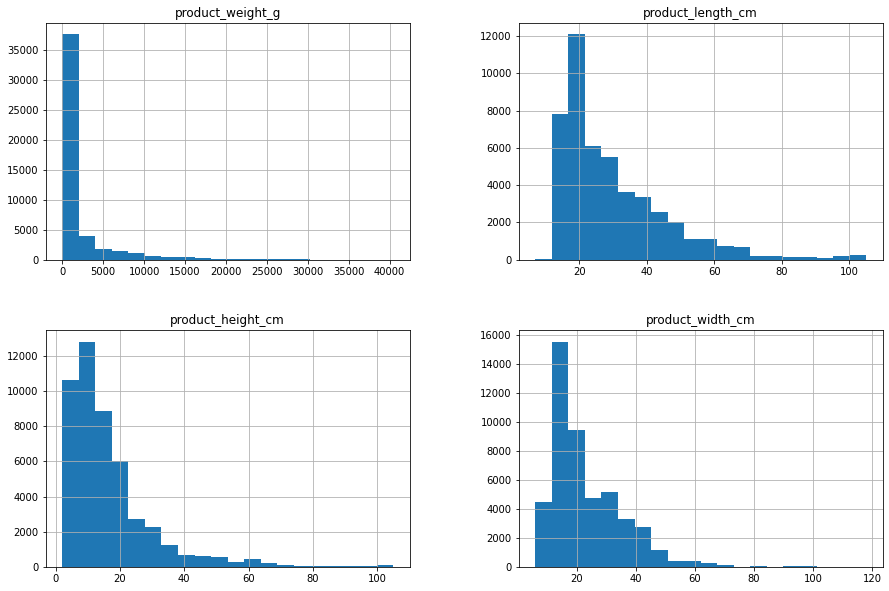

In [ ]:
dfsp[['product_weight_g','product_length_cm','product_height_cm','product_width_cm']].hist(bins=20,figsize=(15,10));

Percebe-se que o peso da maioria dos produtos estão entre os suportados pelos drones. Os valores que ultrapassarem as 8000g seram desconsiderados. Além disso, os produtos que tiverem dimensão superior a 80cm em qualquer uma das suas dimesões serao descartados pois existe a viabilidade das embalagens para transporte. 

In [ ]:
# Adequação aos padrões da analise
dfsp1= dfsp[(dfsp['product_height_cm'] <= 80) & (dfsp['product_length_cm']<= 80) & (dfsp['product_width_cm'] < 80) & (dfsp['product_weight_g']< 8000) ]

In [ ]:
# Porcentagem dos valores retirados
print(f"Para adequar aos padrões da analise foram retirados {(1-(dfsp1.shape[0]/dfsp_antes)) * 100 :.5} % dos dados. ") 

Para adequar aos padrões da analise foram retirados 12.627 % dos dados. 


##3. Distância percorrida

Para criar uma projeção mais realista possível, é necessário calcular a distância que o drone terá que percorrer entre o vendedor e o cliente. Todavia, essa distância terá um erro que ainda não é possivel de ser calculado em virtude das chamadas aerovias, que são verdadeiras avenidas aéras onde os drones iram percorrer até a cidade de entrega dos produtos. Essas aerovias para drones terão que respeitar regras da ANAC como não sobrevoar areas urbanas ou em rota de outras aeronaves. De todo modo, acreditando que essas aerovias ligaram todos os municipios do estado de São Paulo, a distância será calculada com base no CEP dos muicipios entre vendedor e cliente. 

In [ ]:
geolocalizacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


Para o CEP de determinadas cidades de São Paulo precisaremos do the jump of cat, pois várias cidades tem mais de um CEP. Para contornar esse problema, agruparemos os CEPs de uma mesma cidade através da média dos seus valores.

In [ ]:
geo_state_sp = geolocalizacao[geolocalizacao['geolocation_state']=='SP']
geo_state = geo_state_sp.groupby('geolocation_city')['geolocation_lat','geolocation_lng'].mean().reset_index()
geo_state

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,geolocation_city,geolocation_lat,geolocation_lng
0,adamantina,-21.695743,-51.046362
1,adolfo,-21.234456,-49.642716
2,agisse,-23.537329,-48.544934
3,agua vermelha,-21.893562,-47.890985
4,aguai,-22.057066,-46.976182
...,...,...,...
1043,águas de são pedro,-22.603201,-47.870245
1044,álvares florence,-20.322727,-49.906896
1045,álvares machado,-22.079381,-51.470482
1046,álvaro de carvalho,-22.078904,-49.721423


In [ ]:
dfsp1.info()

In [ ]:
dfsp1 = dfsp1.merge(geo_state, how='left',left_on='customer_city',right_on='geolocation_city')

In [ ]:
dfsp1.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,geolocation_city,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP,sao paulo,-23.570860,-46.633242
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP,sao paulo,-23.570860,-46.633242
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP,sao paulo,-23.570860,-46.633242
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP,sao paulo,-23.570860,-46.633242
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP,sao paulo,-23.570860,-46.633242
5,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23,1.0,b00a32a0b42fd65efb58a5822009f629,...,02c9e0c05a817d4562ec0e8c90f29dba,8577,itaquaquecetuba,SP,9350.0,maua,SP,itaquaquecetuba,-23.470259,-46.342773
6,88407c8c6e12493ff6e845df39540112,e902cb9d9992a69a267f69dec57aa3a3,delivered,2017-08-15 02:03:01,2017-08-15 02:15:13,2017-08-16 15:52:29,2017-08-25 21:59:26,2017-08-28,1.0,b00a32a0b42fd65efb58a5822009f629,...,28adbfbaf0b9c5e5a0555a8c853a7534,13060,campinas,SP,9350.0,maua,SP,campinas,-22.900868,-47.068537
7,019aaee09698daf81dcffe9d94a18b5c,e3893e579755de4feb1a4d0313c103fa,delivered,2017-08-10 14:04:58,2017-08-10 14:23:38,2017-08-11 13:52:35,2017-08-12 11:56:49,2017-08-23,1.0,b00a32a0b42fd65efb58a5822009f629,...,cd6b577df45c00daa6b2767eaa947c72,13092,campinas,SP,9350.0,maua,SP,campinas,-22.900868,-47.068537
8,a0151737f2f0c6c0a5fd69d45f66ceea,fc2697314ab7fbeda62bb6f1afa4efcd,delivered,2017-07-12 14:11:58,2017-07-12 14:30:18,2017-07-13 12:47:05,2017-07-18 16:24:42,2017-07-25,1.0,725cbfcaff95a4d43742fdf13cf43c75,...,bdd30e6e39cc70dde8665187b57af402,13820,jaguariuna,SP,9350.0,maua,SP,jaguariuna,-22.693354,-46.987836
9,a3bf941183211246f0d42ad757cba127,3718e1873d5dc3e8d96c0ab783278b02,delivered,2017-07-24 22:16:25,2017-07-25 22:25:11,2017-07-26 14:57:42,2017-07-28 19:06:46,2017-08-04,1.0,725cbfcaff95a4d43742fdf13cf43c75,...,1bcb517dc3cc80868d2fa941174f386c,6298,osasco,SP,9350.0,maua,SP,osasco,-23.536561,-46.788284


#Análise em construção...